# Выбор локации для скважины

**Описание проекта**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Основные этапы  выполнения задачи:**

- Загрузить и подготовьте данные;
- Обучить и проверьте модель для каждого региона;
- Подготовится к расчёту прибыли;
- Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели;
- Посчитать риски и прибыль для каждого региона;
- Написать общий вывод.


**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv.


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**


- Для обучения модели подходит только линейная регрессия;
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [1]:
!pip install phik -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM = 42

## Загрузка и подготовка данных

### Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним его в датафрейм

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Изучим информацию о датафреймах

In [3]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_data_0.shape, geo_data_1.shape, geo_data_2.shape

((100000, 5), (100000, 5), (100000, 5))

Типы данных соответсвуют действительности.

### Проверим на наличие пропусков и дубликатов

In [10]:
def skips_dulicates(data):
    total_missing = data.isna().sum().sum()
    if total_missing > 0:
        print(f"Пропуски найдены, общее количество пропусков: {total_missing}")
        print("Пропуски по столбцам:")
        print(data.isna().sum())
    else:
        print("Пропусков нет.")
    duplicate_count = data.duplicated().sum()
    if duplicate_count > 0:
        print(f"Количество явных дубликатов: {duplicate_count}")
    else:
        print("Дубликатов нет.")
    return data

In [11]:
skips_dulicates(geo_data_0);

Пропусков нет.
Дубликатов нет.


In [12]:
skips_dulicates(geo_data_1);

Пропусков нет.
Дубликатов нет.


In [13]:
skips_dulicates(geo_data_2);

Пропусков нет.
Дубликатов нет.


Пропусков и явных дубликатов не обнаружено. Неявных дубликатов в данных нет, т.к. смысловые столбцы имеют тип float.

### Проведем исследовательский анализ данных

In [14]:
geo_data_0.describe(), geo_data_1.describe(), geo_data_2.describe()

(                  f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        0.500419       0.250143       2.502647      92.500000
 std         0.871832       0.504433       3.248248      44.288691
 min        -1.408605      -0.848218     -12.088328       0.000000
 25%        -0.072580      -0.200881       0.287748      56.497507
 50%         0.502360       0.250252       2.515969      91.849972
 75%         1.073581       0.700646       4.715088     128.564089
 max         2.362331       1.343769      16.003790     185.364347,
                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        1.141296      -4.796579       2.494541      68.825000
 std         8.965932       5.119872       1.703572      45.944423
 min       -31.609576     -26.358598      -0.018144       0.000000
 25%        -6.298551      -8.267985       1.000021      26.9

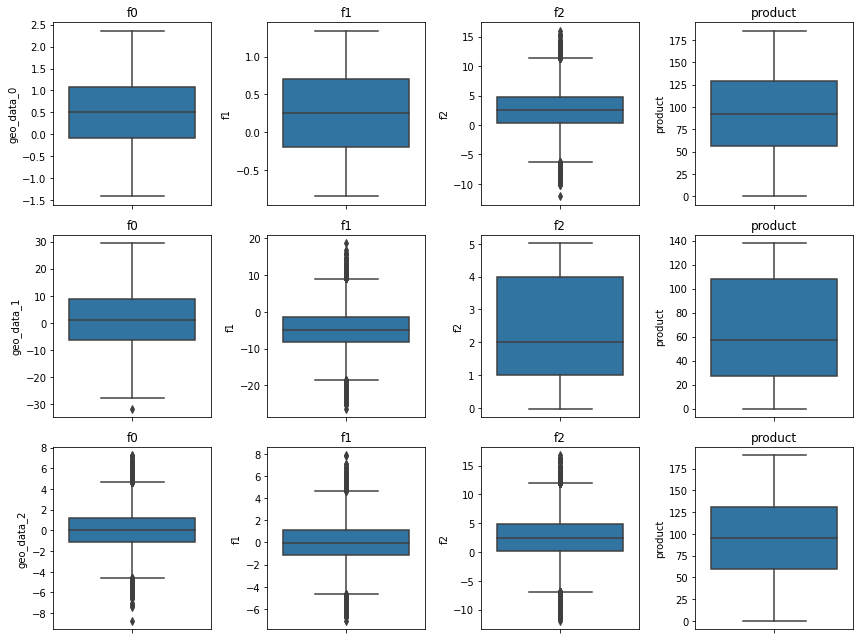

In [15]:
geo_data_list = [geo_data_0, geo_data_1, geo_data_2]
titles = ['geo_data_0', 'geo_data_1', 'geo_data_2']

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

columns_to_plot = ['f0', 'f1', 'f2', 'product']


for i, (data, title) in enumerate(zip(geo_data_list, titles)):
    for j, col in enumerate(columns_to_plot):
        sns.boxplot(y=data[col], ax=axes[i, j])
        axes[i, j].set_title(col)
        axes[i, j].set_xlabel("")
        if j == 0:
            axes[i, j].set_ylabel(title)  
plt.tight_layout()
plt.show()

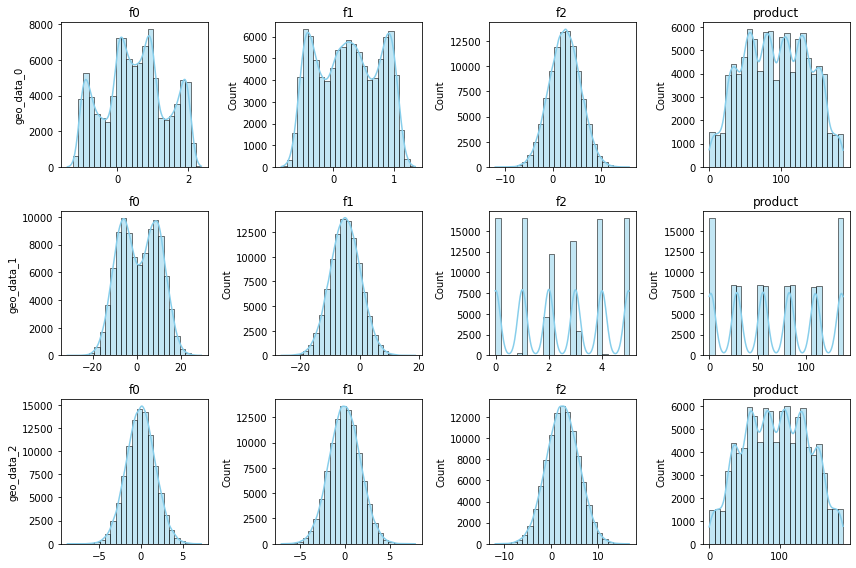

In [16]:
fig, axes = plt.subplots(len(geo_data_list), len(columns_to_plot), figsize=(12, 8))

for i, (data, title) in enumerate(zip(geo_data_list, titles)):
    for j, col in enumerate(columns_to_plot):
        sns.histplot(data[col], bins=25, kde=True, ax=axes[i, j], color="skyblue", edgecolor="black")
        axes[i, j].set_title(col)
        axes[i, j].set_xlabel("")
        if j == 0:
            axes[i, j].set_ylabel(title)

plt.tight_layout()
plt.show()

В таблицах присутствуют аномальные значения. Распределения в geo_data_1 для `f2` и `product` похожи на изолированные столбцы, что означает, что все значения разбиты на группы с очень близко стоящими друг к другу значениями.

In [17]:
def anomaly_count(data, column, remove_anomalies=True):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data_cleaned = data.dropna(subset=[column])
    
    q1 = np.percentile(data_cleaned[column], 25)
    q3 = np.percentile(data_cleaned[column], 75)  
    
    IQR = q3 - q1
    
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    outliers = data_cleaned[(data_cleaned[column] < lower_bound) | (data_cleaned[column] > upper_bound)]
    outlier_percent = len(outliers) / len(data_cleaned) * 100  
    
    if remove_anomalies:
        filtered_data = data_cleaned[(data_cleaned[column] >= lower_bound) & (data_cleaned[column] <= upper_bound)]
        return len(outliers), outlier_percent, filtered_data
    else:
        return len(outliers), outlier_percent

In [18]:
outliers_count_0, outliers_percent_0, geo_data_0 = anomaly_count(geo_data_0, 'f2')
print(outliers_percent_0)

0.506


0.5% значений являются аномальными.

In [19]:
outliers_count_1, outliers_percent_1, geo_data_1 = anomaly_count(geo_data_1, 'f0')
print(outliers_percent_1)

0.001


In [20]:
outliers_count_2, outliers_percent_2, geo_data_1 = anomaly_count(geo_data_1, 'f1')
print(outliers_percent_2)

0.6360063600636007


Около 0.6% являются аномальными.

In [21]:
outliers_count_3, outliers_percent_3, geo_data_2 = anomaly_count(geo_data_2, 'f0')
print(outliers_percent_3)

0.733


In [22]:
outliers_count_4, outliers_percent_4, geo_data_2 = anomaly_count(geo_data_2, 'f1')
print(outliers_percent_4)

0.6870359736871267


In [23]:
outliers_count_5, outliers_percent_5, geo_data_2 =  anomaly_count(geo_data_2, 'f2')
print(outliers_percent_5)

0.590353502054065


Около 2% являются аномальными.

Количество аномальных значений очень мало, их можно удалить.

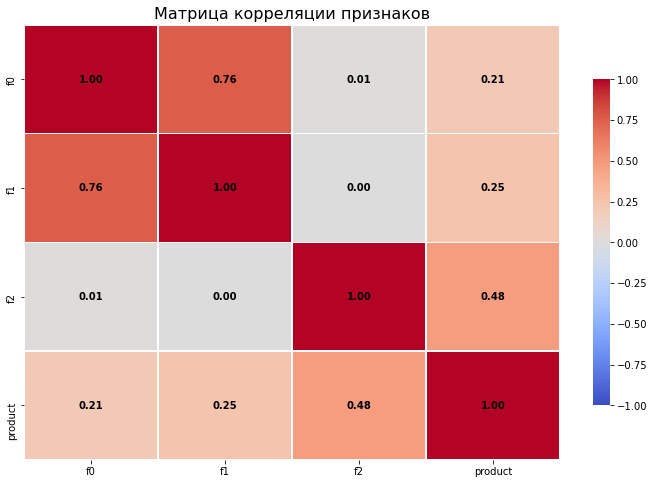

In [24]:
interval_cols = [
    'f0', 'f1', 'f2', 'product'
]

phik_matrix = geo_data_0.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)


plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",            
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

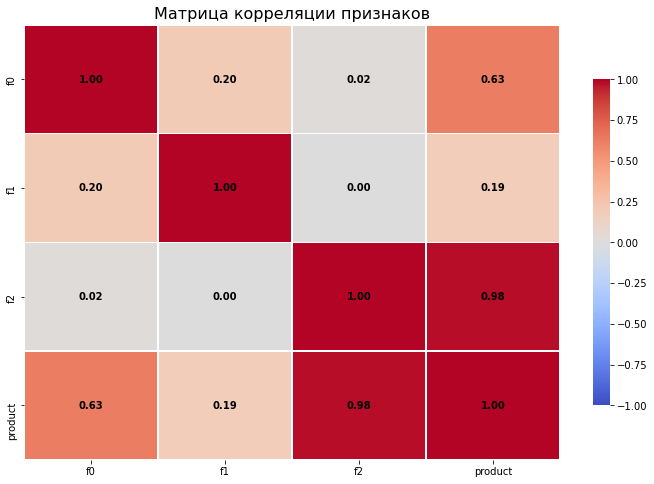

In [25]:
phik_matrix = geo_data_1.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)


plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",           
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

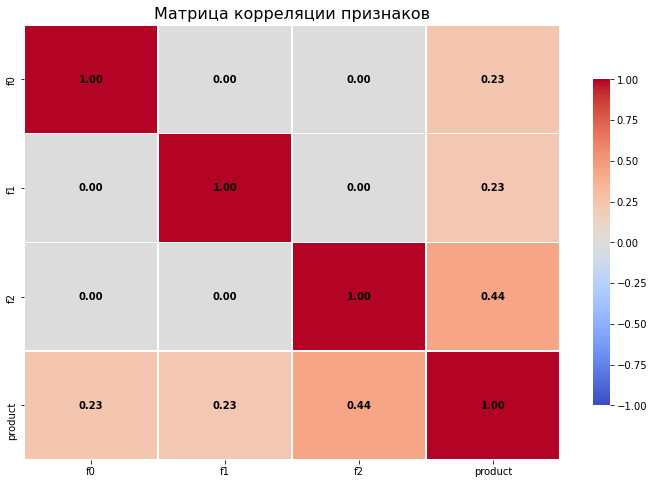

In [26]:
phik_matrix = geo_data_2.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",           
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

В geo_data_0 присутствует достаточно сильная корреляция между f0 и f1. f2 коррелирует только с product.

В geo_data_1 присутствует очень сильная корреляция между f2 и product. Скорее всего в данном случае признак обладает потенциально высокой предиктивной способностью в рамках наших данных.

В geo_data_2 с целевым лучше всего коррелирует f2.

**Типы данных соответсвуют действительности. Пропусков и дубликатов не обнаружено. Были обнаружены и удалены аномальные значения, проведен корреляционный анализ.**

## Обучение и проверка модели

In [27]:
def model(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    
    
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=RANDOM)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid, y_pred)**0.5
    stock = y_pred.mean()
    
    print(f'Средний запас предполагаемого сырья:{stock:.4f}')
    print(f'Метрика RMSE:{rmse:.4f}')
       
    return y_valid, y_pred, stock, rmse

In [28]:
y_valid_0, y_pred_0, stock_0, rmse_0 = model(geo_data_0);

Средний запас предполагаемого сырья:92.3505
Метрика RMSE:37.8151


In [29]:
y_valid_1, y_pred_1, stock_1, rmse_1 = model(geo_data_1);

Средний запас предполагаемого сырья:68.9619
Метрика RMSE:0.8880


In [30]:
y_valid_2, y_pred_2, stock_2, rmse_2 = model(geo_data_2);

Средний запас предполагаемого сырья:94.9518
Метрика RMSE:40.1296


Первый регион имеет второй по величине запас. Второй проигрывает другим по параметру среднего запаса, но выигрывает по метрике. Третий регион выигрывает по величине сырья, но уступает по метрике певрому. 

## Подготовка к расчёту прибыли

In [31]:
max_points = 500
selected_points = 200
budget_per_region = 10*10**9
price_per_barrel = 450000
threshold = 2.5

In [32]:
min_volume_per_well = (budget_per_region / selected_points) / price_per_barrel 
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {min_volume_per_well}')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111


In [33]:
# отклонение от среднего в регионе_0
stock_0 - min_volume_per_well

-18.760564146440316

In [34]:
# отклонение от среднего в регионе_1
stock_1 - min_volume_per_well

-42.14921213194644

In [35]:
# отклонение от среднего в регионе_2
stock_2 - min_volume_per_well

-16.159330003492812

Достаточный объём сырья для безубыточной разработки новой скважины: 111.(1).

В каждом из трёх регионов средний запас сырья скважины меньше полученного значения достаточного объёма сырья.

## Расчёт прибыли и рисков 

### Расчёт прибыли по выбранным скважинам и предсказаниям модели

In [36]:
def calculate_profit(target, predictions, selected_points=200, budget_per_region=10*10**9, price_per_barrel=450000):
    target = target.reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    
    selected_indices = predictions.nlargest(selected_points).index
    selected_target = target.iloc[selected_indices]

    total_profit = (selected_target.sum() * price_per_barrel) - budget_per_region
    
    return total_profit

In [37]:
profit_0 = calculate_profit(y_valid_0, y_pred_0)
print(f"Прибыль в 0 регионе: {profit_0:.2f} руб.")

Прибыль в 0 регионе: 3252359903.11 руб.


In [38]:
profit_1 = calculate_profit(y_valid_1, y_pred_1)
print(f"Прибыль в 1 регионе: {profit_1:.2f} руб.")

Прибыль в 1 регионе: 2415086696.68 руб.


In [39]:
profit_2 = calculate_profit(y_valid_2, y_pred_2)
print(f"Прибыль в 2 регионе: {profit_2:.2f} руб.")

Прибыль в 2 регионе: 2385314465.93 руб.


### Расчет рисков и прибыли

In [40]:
def bootstrap_profit(target, predictions, max_points=500, budget_per_region=10e9, price_per_barrel=450000, n_iterations=1000):
    state = np.random.RandomState(12345)
    values = []
    
    target = target.reset_index(drop=True)  
    predictions = pd.Series(predictions).reset_index(drop=True) 
    
    for _ in range(n_iterations):
       
        target_subsample = target.sample(n=max_points, replace=True, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index] 
        
        profit = calculate_profit(target_subsample, predictions_subsample)
        values.append(profit)
    
    values = pd.Series(values)
    

    print(f'Средняя прибыль: {values.mean():,.2f}')
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print(f'95%-й доверительный интервал: [{lower:,.2f}, {upper:,.2f}]')
    
    loss_risk = (values < 0).mean() * 100 
    print(f'Риск убытков: {loss_risk:.2f}%')
    
    return round(lower, 2), round(upper, 2), loss_risk


In [41]:
bootstrap_profit(y_valid_0, y_pred_0)

Средняя прибыль: 393,086,331.86
95%-й доверительный интервал: [-146,392,843.70, 898,526,291.75]
Риск убытков: 6.60%


(-146392843.7, 898526291.75, 6.6000000000000005)

In [42]:
bootstrap_profit(y_valid_1, y_pred_1)

Средняя прибыль: 455,772,670.52
95%-й доверительный интервал: [55,766,165.53, 851,765,420.27]
Риск убытков: 1.50%


(55766165.53, 851765420.27, 1.5)

In [43]:
bootstrap_profit(y_valid_2, y_pred_2)

Средняя прибыль: 375,536,745.74
95%-й доверительный интервал: [-136,944,412.12, 857,034,891.82]
Риск убытков: 7.70%


(-136944412.12, 857034891.82, 7.7)

В регионе 0 средняя прибыль составляет 393,09 млн. 95%-й доверительный интервал: от -146,39 млн до 898,53 млн. Риск убытков: 6,6%. Для этого региона  есть вероятность убытков, с возможными  колебаниями в пределах доверительного интервала. 


В регионе 1 средняя прибыль составляет 455,77 млн. 95%-й доверительный интервал: от 55,77 млн до 851,77 млн. Риск убытков: 1,5%. Регион 1 показывает наибольшую среднюю прибыль и самый низкий риск убытков среди всех рассмотренных регионов. Более того, доверительный интервал не включает отрицательные значения, что свидетельствует о стабильности и относительно низком уровне неопределённости.

В регионе 2 средняя прибыль составляет 375,54 млн. 95%-й доверительный интервал: от -136,94 млн до 857,03 млн. Риск убытков: 7,7%. В регионе 2 наблюдается риск убытков и колебания прибыли.


С учетом анализа выше, Регион 1 выглядит наиболее перспективным для разработки скважин, так как он демонстрирует наибольшую среднюю прибыль, низкий риск убытков и более стабильный результат по сравнению с другими регионами.

## Общий вывод

**Описание проекта**

Необходимо решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:

- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv.
- /datasets/geo_data_2.csv.


id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).


В ходе изучения данных было обнаружено, что в таблицах присутствуют аномальные значения. Распределения в geo_data_1 для f2 и product похожи на изолированные столбцы, что означает, что все значения разбиты на группы с очень близко стоящими друг к другу значениями. Количество аномальных значений оказалось очень мало, они были удалены.

В результате корреляционного анализа было найдено, что в geo_data_0 присутствует достаточно сильная корреляция между f0 и f1. f2 коррелирует только с product. В geo_data_1 присутствует очень сильная корреляция между f2 и product. Скорее всего в данном случае признак обладает потенциально высокой предиктивной способностью в рамках наших данных. В geo_data_2 с целевым лучше всего коррелирует f2.

Была разработана модель линейной регрессии. Таким образом, первый регион имеет второй по величине запас, второй проигрывает другим по параметру среднего запаса, но выигрывает по метрике, третий регион выигрывает по величине сырья, но уступает по метрике певрому.

Достаточный объём сырья для безубыточной разработки новой скважины составил: 111.(1). В каждом из трёх регионов средний запас сырья скважины меньше полученного значения достаточного объёма сырья.

Были расчитана прибыли и риски. В регионе 0 средняя прибыль составляет 393,09 млн. 95%-й доверительный интервал: от -146,39 млн до 898,53 млн. Риск убытков: 6,6%. Для этого региона есть вероятность убытков, с возможными колебаниями в пределах доверительного интервала.

В регионе 1 средняя прибыль составляет 455,77 млн. 95%-й доверительный интервал: от 55,77 млн до 851,77 млн. Риск убытков: 1,5%. Регион 1 показывает наибольшую среднюю прибыль и самый низкий риск убытков среди всех рассмотренных регионов. Более того, доверительный интервал не включает отрицательные значения, что свидетельствует о стабильности и относительно низком уровне неопределённости.

В регионе 2 средняя прибыль составляет 375,54 млн. 95%-й доверительный интервал: от -136,94 млн до 857,03 млн. Риск убытков: 7,7%. В регионе 2 наблюдается риск убытков и колебания прибыли.

С учетом анализа выше, Регион 1 выглядит наиболее перспективным для разработки скважин, так как он демонстрирует наибольшую среднюю прибыль, низкий риск убытков и более стабильный результат по сравнению с другими регионами.